In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from utils import DataPreprocessing, SpectrogramDataset, plot_waveform, plot_spectrogram
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

ROOT_PATH = os.getcwd()

RAW_DATASET_PATH = os.path.join(ROOT_PATH, "dataset", "raw")
PRODUCTION_DATASET_PATH = os.path.join(ROOT_PATH, "dataset", "production")
LOGS_PATH = os.path.join(ROOT_PATH, "logs")
MODELS_PATH = os.path.join(ROOT_PATH, "models")

SUBSAMPLE_SIZE = 10000
NOISE_RATIO = 0.5
EARTHQUAKE_RATIO = 0.5

2.6.0
None
False


In [2]:
def preprocess_data():
	"""Computes, saves, and prints summary of preprocessed data."""

	# Compute preprocessed data
	data_processor = DataPreprocessing(
		subsample_size=SUBSAMPLE_SIZE,
		raw_dataset_path=RAW_DATASET_PATH,
		logs_path=LOGS_PATH,
		noise_ratio=NOISE_RATIO,
		earthquake_ratio=EARTHQUAKE_RATIO
	)

	# Save preprocessed data
	signals = data_processor.subsample_traces
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"signals_{SUBSAMPLE_SIZE}.npy"), np.array(list(signals.values())))
	metadata = data_processor.subsample_metadata
	metadata.to_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
	waveform_images = data_processor.create_waveform_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"), waveform_images)
	spectrogram_images = data_processor.create_spectrogram_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"), spectrogram_images)

	# Print summary of preprocessed data
	print(
		f"""
		1. Expected samples: {SUBSAMPLE_SIZE}
		2. Actual samples: {len(signals)}\n{metadata['category'].value_counts(normalize=True)}
		"""
	)

# preprocess_data()

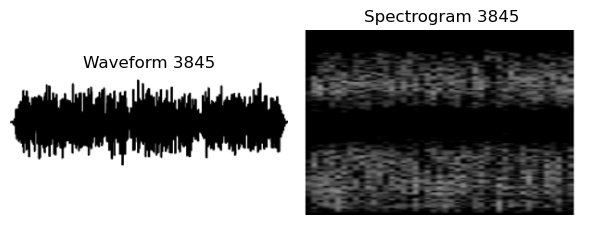

In [2]:
def visualise_data(num_samples=1):
	"""Randomly selects a pair of waveform and spectrogram images to plot."""

	# Load saved images
	waveform_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"))
	spectrogram_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))

	# Create figure with subplots
	fig, axes = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))

	# Ensure axes is iterable for a single sample case
	if num_samples == 1:
		axes = [axes]

	# Plot random images
	for i1, i2 in enumerate(np.random.choice(len(waveform_images), num_samples, replace=False)):
		axes[i1][0].imshow(waveform_images[i2])
		axes[i1][0].set_title(f"Waveform {i2}")
		axes[i1][0].axis("off")
		axes[i1][1].imshow(spectrogram_images[i2])
		axes[i1][1].set_title(f"Spectrogram {i2}")
		axes[i1][1].axis("off")
	plt.tight_layout()
	plt.show()

visualise_data()

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 37
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 7

# Load production dataset and compute labels
spectrograms = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))
metadata = pd.read_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
labels = (metadata["category"] == "earthquake").astype(np.float32).values  # 0 (noise), 1 (earthquake)

# Normalize and convert spectrograms and labels to tensors
spectrograms = torch.tensor(spectrograms.astype(np.float32) / 255.0).permute(0, 3, 1, 2)
labels = torch.tensor(labels).view(-1, 1)

def split_data(spectrograms, labels, test_size=0.2, dev_size=0.5):
	"""This is a concise line specifying what this function does."""
	train_i, temp_i, train_labels, temp_labels = train_test_split(spectrograms, labels, test_size=test_size, stratify=labels, random_state=SEED)
	dev_i, test_i, dev_labels, test_labels = train_test_split(temp_i, temp_labels, test_size=dev_size, stratify=temp_labels, random_state=SEED)
	return train_i, train_labels, dev_i, dev_labels, test_i, test_labels

# Split production dataset into train, dev, and test sets
train_i, train_labels, dev_i, dev_labels, test_i, test_labels = split_data(spectrograms, labels)

# Convert train, dev, and test sets to train, dev, and test loaders
train_loader = DataLoader(SpectrogramDataset(train_i, train_labels), batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(SpectrogramDataset(dev_i, dev_labels), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(SpectrogramDataset(test_i, test_labels), batch_size=BATCH_SIZE, shuffle=False)

In [10]:
import random
from collections import deque

class SomnialUnit(nn.Module):
	def __init__(self, in_channels, k=10):
		super().__init__()
		self.M = deque(maxlen=k)
		self.delta = nn.Conv2d(in_channels, in_channels, kernel_size=1)
		self.beta = nn.Sequential(
			nn.Conv2d(in_channels * 2, in_channels, kernel_size=3, padding=1), nn.ReLU()
		)

	def forward(self, x_t):
		self.M.append(x_t.detach())
		x_s = random.choice(self.M)
		if x_s.shape[0] != x_t.shape[0]:
			pad_size = x_t.shape[0] - x_s.shape[0]
			if pad_size > 0:
				x_s = torch.cat([x_s, torch.zeros((pad_size, *x_s.shape[1:]), device=x_t.device)], dim=0)
			else:
				x_s = x_s[:x_t.shape[0]]
		x_s_hat = self.delta(x_s)
		g = self.beta(torch.cat([x_t, x_s_hat], dim=1))
		return g * x_s_hat + (1 - g) * x_t

class CNN(nn.Module):
	def __init__(self):
		super().__init__()
		self.id = "CNN"
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.su = SomnialUnit(in_channels=64)
		self.fc1 = nn.Linear(64 * 25 * 37, 128)
		self.fc2 = nn.Linear(128, 16)
		# self.fc3 = nn.Linear(32, 16)
		self.fc4 = nn.Linear(16, 1)
		self.pool = nn.MaxPool2d(2, 2)
		self.dropout = nn.Dropout(0.25)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.pool(F.relu(self.conv3(x)))
		x = self.su(x)
		x = torch.flatten(x, 1)
		x = self.dropout(F.relu(self.fc1(x)))
		# x = self.dropout(F.relu(self.fc2(x)))
		x = torch.sigmoid(self.fc4(F.relu(self.fc2(x))))
		return x

In [ ]:
def train_model(model, train_loader, dev_loader, criterion, optimizer):
	# Create model folder
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	os.makedirs(model_folder, exist_ok=True)

	best_dev_loss = float("inf")
	best_model_path = os.path.join(model_folder, "best.pth")
	patience_counter = 0
	train_losses = []
	dev_losses = []

	for epoch in range(NUM_EPOCHS):
		# Train model on train set
		model.train()
		total_loss = 0
		for images, labels in train_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		train_loss = total_loss / len(train_loader)
		train_losses.append(train_loss)

		# Evaluate model on dev set
		model.eval()
		dev_loss = 0
		with torch.no_grad():
			for images, labels in dev_loader:
				images, labels = images.to(DEVICE), labels.to(DEVICE)
				outputs = model(images)
				dev_loss += criterion(outputs, labels).item()
		dev_loss /= len(dev_loader)
		dev_losses.append(dev_loss)

		print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Dev Loss: {dev_loss:.4f}")

		# Save model epoch checkpoint
		torch.save(model.state_dict(), os.path.join(model_folder, f"epoch={epoch+1}-dev_loss={dev_loss:.4f}.pth"))

		if dev_loss < best_dev_loss:
			best_dev_loss = dev_loss
			torch.save(model.state_dict(), best_model_path)  # Save best model
			patience_counter = 0  # Reset patience counter
		else:
			patience_counter += 1
			# Stop early if needed
			if patience_counter >= PATIENCE:
				print("Stopping early")
				break

	# Save losses
	loss_data = {"train_losses": train_losses, "dev_losses": dev_losses}
	with open(os.path.join(model_folder, "losses.json"), "w") as f:
		json.dump(loss_data, f)

In [21]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque

class SomnialUnit(nn.Module):
	def __init__(self, in_channels, k=10):
		super().__init__()
		self.M = deque(maxlen=k)
		self.delta = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size=1), nn.ReLU())
		self.beta = nn.Sequential(nn.Conv2d(in_channels * 2, in_channels, kernel_size=3, padding=1), nn.ReLU())

	def forward(self, x_t, confidence_model=None):
		self.M.append(x_t.detach())

		if confidence_model is not None and self.M:
			with torch.no_grad():
				confidences = [
					torch.abs(confidence_model(x.unsqueeze(0).unsqueeze(0)) - 0.5)  # Add an extra batch dimension
					for x in self.M
				]
			x_s = self.M[torch.argmin(torch.tensor(confidences)).item()]
		else:
			x_s = random.choice(self.M)

		if x_s.shape[0] != x_t.shape[0]:
			pad_size = x_t.shape[0] - x_s.shape[0]
			x_s = torch.cat([x_s, torch.zeros((pad_size, *x_s.shape[1:]), device=x_t.device)], dim=0) if pad_size > 0 else x_s[:x_t.shape[0]]

		x_s_hat = self.delta(x_s)
		g = self.beta(torch.cat([x_t, x_s_hat], dim=1))
		return g * x_s_hat + (1 - g) * x_t

class CNN(nn.Module):
	def __init__(self):
		super().__init__()
		self.id = "CNN"
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.su = SomnialUnit(in_channels=64)
		self.fc1 = nn.Linear(64 * 25 * 37, 128)
		self.fc2 = nn.Linear(128, 16)
		self.fc4 = nn.Linear(16, 1)
		self.pool = nn.MaxPool2d(2, 2)
		self.dropout = nn.Dropout(0.25)
		self.confidence_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(64, 1))

	def forward(self, x):  # <-- Remove model argument
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.pool(F.relu(self.conv3(x)))
		x = self.su(x, confidence_model=self.confidence_head)  # Pass confidence head
		x = torch.flatten(x, 1)
		x = self.dropout(F.relu(self.fc1(x)))
		x = torch.sigmoid(self.fc4(F.relu(self.fc2(x))))
		return x


def train_model(model, train_loader, dev_loader, criterion, optimizer):
	# Create model folder
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	os.makedirs(model_folder, exist_ok=True)

	best_dev_loss = float("inf")
	best_model_path = os.path.join(model_folder, "best.pth")
	patience_counter = 0
	train_losses = []
	dev_losses = []

	for epoch in range(NUM_EPOCHS):
		# Train model on train set
		model.train()
		total_loss = 0
		for images, labels in train_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss += 0.1 * torch.abs(model(x_s_hat.unsqueeze(0)) - 0.5).mean()
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		train_loss = total_loss / len(train_loader)
		train_losses.append(train_loss)

		# Evaluate model on dev set
		model.eval()
		dev_loss = 0
		with torch.no_grad():
			for images, labels in dev_loader:
				images, labels = images.to(DEVICE), labels.to(DEVICE)
				outputs = model(images, model=model)  # <-- Pass model here too
				dev_loss += criterion(outputs, labels).item()
		dev_loss /= len(dev_loader)
		dev_losses.append(dev_loss)

		print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Dev Loss: {dev_loss:.4f}")

		# Save model epoch checkpoint
		torch.save(model.state_dict(), os.path.join(model_folder, f"epoch={epoch+1}-dev_loss={dev_loss:.4f}.pth"))

		if dev_loss < best_dev_loss:
			best_dev_loss = dev_loss
			torch.save(model.state_dict(), best_model_path)  # Save best model
			patience_counter = 0  # Reset patience counter
		else:
			patience_counter += 1
			# Stop early if needed
			if patience_counter >= PATIENCE:
				print("Stopping early")
				break

	# Save losses
	loss_data = {"train_losses": train_losses, "dev_losses": dev_losses}
	with open(os.path.join(model_folder, "losses.json"), "w") as f:
		json.dump(loss_data, f)

In [30]:
###

import random
from collections import deque

class SomnialUnit(nn.Module):
	def __init__(self, in_channels, k=10):
		super().__init__()
		self.M = deque(maxlen=k)
		self.delta = nn.Conv2d(in_channels, in_channels, kernel_size=1)
		self.beta = nn.Sequential(
			nn.Conv2d(in_channels * 2, in_channels, kernel_size=3, padding=1), nn.ReLU()
		)

	def forward(self, x_t):
		self.M.append(x_t.detach())
		x_s = random.choice(self.M)
		if x_s.shape[0] != x_t.shape[0]:
			pad_size = x_t.shape[0] - x_s.shape[0]
			if pad_size > 0:
				x_s = torch.cat([x_s, torch.zeros((pad_size, *x_s.shape[1:]), device=x_t.device)], dim=0)
			else:
				x_s = x_s[:x_t.shape[0]]
		x_s_hat = self.delta(x_s)
		g = self.beta(torch.cat([x_t, x_s_hat], dim=1))
		return g * x_s_hat + (1 - g) * x_t

class CNN(nn.Module):
	def __init__(self):
		super().__init__()
		self.id = "CNN"
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.su = SomnialUnit(in_channels=64)
		self.fc1 = nn.Linear(64 * 25 * 37, 128)
		self.fc2 = nn.Linear(128, 16)
		# self.fc3 = nn.Linear(32, 16)
		self.fc4 = nn.Linear(16, 1)
		self.pool = nn.MaxPool2d(2, 2)
		self.dropout = nn.Dropout(0.25)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.pool(F.relu(self.conv3(x)))
		x = self.su(x)
		x = torch.flatten(x, 1)
		x = self.dropout(F.relu(self.fc1(x)))
		# x = self.dropout(F.relu(self.fc2(x)))
		x = torch.sigmoid(self.fc4(F.relu(self.fc2(x))))
		return x

class SomnialUnitV2(nn.Module):
	def __init__(self, in_channels, k=10, epsilon=0.01):
		super().__init__()
		self.M = deque(maxlen=k)
		# self.delta = nn.Conv2d(in_channels, in_channels, kernel_size=1)
		self.beta = nn.Sequential(
			nn.Conv2d(in_channels * 2, in_channels, kernel_size=3, padding=1),
			nn.ReLU()
		)
		self.epsilon = epsilon

	def forward(self, x_t, model=None):
		self.M.append(x_t.detach())
		x_s = random.choice(self.M)

		if x_s.shape[0] != x_t.shape[0]:
			pad_size = x_t.shape[0] - x_s.shape[0]
			if pad_size > 0:
				x_s = torch.cat([x_s, torch.zeros((pad_size, *x_s.shape[1:]), device=x_t.device)], dim=0)
			else:
				x_s = x_s[:x_t.shape[0]]

		x_s_hat = x_s
		if model is not None:
			x_s_hat.requires_grad = True
			y_s_hat = model(x_s_hat)
			L = F.binary_cross_entropy(y_s_hat, torch.full_like(y_s_hat, 0.5))
			L.backward()
			x_s_hat = (x_s_hat + self.epsilon * x_s_hat.grad.sign()).detach()

		g = self.beta(torch.cat([x_t, x_s_hat], dim=1))
		return g * x_s_hat + (1 - g) * x_t

class SmallCNN(nn.Module):
	def __init__(self):
		super().__init__()
		self.id = "SmallCNN"
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.su = SomnialUnitV2(in_channels=64)
		self.fc1 = nn.Linear(64 * 25 * 37, 4)
		self.fc2 = nn.Linear(4, 1)
		self.pool = nn.MaxPool2d(2, 2)
		self.dropout = nn.Dropout(0.1)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.pool(F.relu(self.conv3(x)))
		x = self.su(x)
		x = torch.flatten(x, 1)
		x = self.dropout(F.relu(self.fc1(x)))
		x = torch.sigmoid(self.fc2(x))
		return x

def train_model(model, train_loader, dev_loader, criterion, optimizer):
	# Create model folder
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	os.makedirs(model_folder, exist_ok=True)

	best_dev_loss = float("inf")
	best_model_path = os.path.join(model_folder, "best.pth")
	patience_counter = 0
	train_losses = []
	dev_losses = []

	for epoch in range(NUM_EPOCHS):
		# Train model on train set
		model.train()
		total_loss = 0
		for images, labels in train_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		train_loss = total_loss / len(train_loader)
		train_losses.append(train_loss)

		# Evaluate model on dev set
		model.eval()
		dev_loss = 0
		with torch.no_grad():
			for images, labels in dev_loader:
				images, labels = images.to(DEVICE), labels.to(DEVICE)
				outputs = model(images)
				dev_loss += criterion(outputs, labels).item()
		dev_loss /= len(dev_loader)
		dev_losses.append(dev_loss)

		print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Dev Loss: {dev_loss:.4f}")

		# Save model epoch checkpoint
		torch.save(model.state_dict(), os.path.join(model_folder, f"epoch={epoch+1}-dev_loss={dev_loss:.4f}.pth"))

		if dev_loss < best_dev_loss:
			best_dev_loss = dev_loss
			torch.save(model.state_dict(), best_model_path)  # Save best model
			patience_counter = 0  # Reset patience counter
		else:
			patience_counter += 1
			# Stop early if needed
			if patience_counter >= PATIENCE:
				print("Stopping early")
				break

	# Save losses
	loss_data = {"train_losses": train_losses, "dev_losses": dev_losses}
	with open(os.path.join(model_folder, "losses.json"), "w") as f:
		json.dump(loss_data, f)

In [31]:
model = SmallCNN().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

train_model(model, train_loader, dev_loader, criterion, optimizer)

KeyboardInterrupt: 

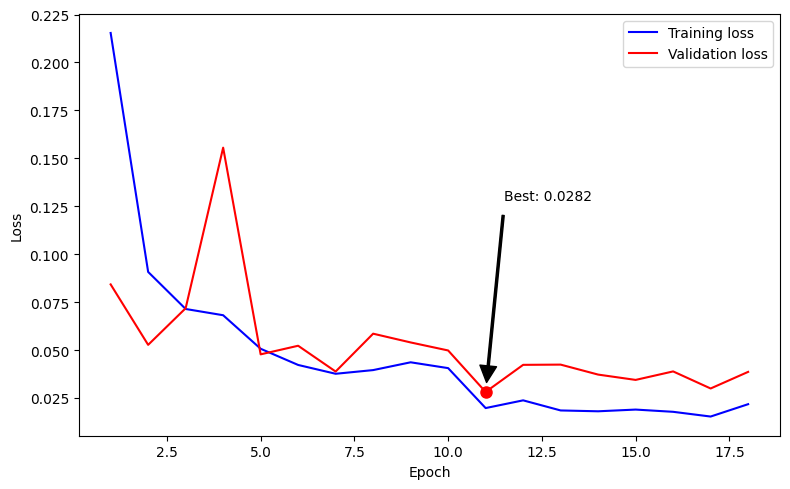

In [13]:
import matplotlib.pyplot as plt

def visualise_training(model):
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	with open(os.path.join(model_folder, "losses.json"), "r") as f:
		loss_data = json.load(f)
	train_losses = loss_data["train_losses"]
	dev_losses = loss_data["dev_losses"]
	plt.figure(figsize=(8, 5))
	epochs = range(1, len(train_losses) + 1)
	plt.plot(epochs, train_losses, 'b-', label='Training loss')
	plt.plot(epochs, dev_losses, 'r-', label='Validation loss')
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	best_epoch = np.argmin(dev_losses) + 1
	best_loss = min(dev_losses)
	plt.plot(best_epoch, best_loss, 'ro', markersize=8)
	plt.annotate(
		f'Best: {best_loss:.4f}',
		xy=(best_epoch, best_loss),
		xytext=(best_epoch + 0.5, best_loss + 0.1),
		arrowprops=dict(facecolor='black', shrink=0.05, width=1.5)
	)
	plt.tight_layout()
	plt.show()

visualise_training(model)

In [14]:
def compute_metrics(y_true, y_pred):
	y_true, y_pred = y_true.cpu().numpy(), (y_pred.cpu().numpy() > 0.5)
	acc = accuracy_score(y_true, y_pred)
	precision = precision_score(y_true, y_pred, zero_division=0)
	recall = recall_score(y_true, y_pred)
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
	tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
	fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
	return {
		"accuracy": round(acc, 5),
		"precision": round(precision, 5),
		"TPR": float(round(tpr, 5)),
		"FPR": float(round(fpr, 5))
	}

def evaluate_model(model, test_loader):
	model.eval()
	y_true, y_pred = [], []

	with torch.no_grad():
		for images, labels in test_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			outputs = model(images)
			y_true.append(labels)
			y_pred.append(outputs)

	y_true = torch.cat(y_true, dim=0)
	y_pred = torch.cat(y_pred, dim=0)
	metrics = compute_metrics(y_true, y_pred)
	print(f"Test Metrics: {{'accuracy': {metrics['accuracy']:.5f}, "
		f"'precision': {metrics['precision']:.5f}, "
		f"'TPR': {metrics['TPR']:.5f}, "
		f"'FPR': {metrics['FPR']:.5f}}}")

model.load_state_dict(torch.load(os.path.join(MODELS_PATH, f"{model.id}", "best.pth")))
evaluate_model(model, test_loader)

Test Metrics: {'accuracy': 0.99400, 'precision': 0.99400, 'TPR': 0.99400, 'FPR': 0.00600}
